# EyeVision Visual Model

**Name Student 1:** Aviv Gerbi
**ID Student 1:** 318947470
<br><br>
**Name Student 2:** Heli Puhovich
**ID Student 2:** 205590367
<br><br>
**Name Student 3:** Noa Shafir
**ID Student 3:** 318812443
<br><br>
**Name Student 4:** Idan Shoshana
**ID Student 4:** 209139468
<br><br>
**Name Student 5:** Dor Shinar
**ID Student 5:** 208614941

## Connecting to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import

In [2]:
import os
import os.path
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import (Activation, Dense, Input, BatchNormalization, concatenate,
                          Conv3D, MaxPooling3D, Dropout, Reshape, Lambda, Flatten)
from keras import Model, optimizers
from keras import backend as K
from keras.utils.data_utils import get_file
from tensorflow import keras
from keras.models import load_model
from keras.models import Sequential

## Hyper Parameters

In [44]:
# Video preprocess
IMG_SIZE = 84
CHANNELS = 3
CHANNELS_OPTICAL_FLOW = 2
MAX_SEQ_LENGTH = 24

# Folder paths 
RealLifeViolenceDataset = '/content/drive/MyDrive/deepLearning/EyeVision-final-project/Real-Life-Violence-Dataset'
RWF2000Dataset = '/content/drive/MyDrive/deepLearning/EyeVision-final-project/RWF-2000'

# Train parameters
BATCH_SIZE = 32
EPOCHS = 10
CLASSES = 1

## Utils

In [4]:
def load_video(path, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = (int(length/MAX_SEQ_LENGTH))
    counter = 0
    frames = []

    try:
      while True:
        counter += 1
        ret, frame = cap.read()
        if not ret:
           break
        frame = cv2.resize(frame, resize)
        frame = frame[:, :, [2, 1, 0]]
        if(counter % step == 0):
          frames.append(frame)
        if len(frames) == MAX_SEQ_LENGTH:
          break

    finally:
        cap.release()
    return np.array(frames)

In [5]:
def get_optical_flow(video_frames):
  gray_frames = []
  flows = []

  for i in range(len(video_frames)):
    img_float32 = np.float32(video_frames[i])
    gray_frame = cv2.cvtColor(img_float32, cv2.COLOR_RGB2GRAY)
    gray_frames.append(np.reshape(gray_frame, (IMG_SIZE, IMG_SIZE, 1)))

  for i in range(0, len(gray_frames) - 1):
    # calculate optical flow between each pair of frames
    flow = cv2.calcOpticalFlowFarneback(prev=gray_frames[i],
                                        next=gray_frames[i + 1],
                                        flow=None,
                                        pyr_scale=0.5,
                                        levels=3,
                                        winsize=15,
                                        iterations=3,
                                        poly_n=5,
                                        poly_sigma=1.2,
                                        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    flow[..., 0] = cv2.normalize(flow[..., 0],None,0,255,cv2.NORM_MINMAX)
    flow[..., 1] = cv2.normalize(flow[..., 1],None,0,255,cv2.NORM_MINMAX)

    flows.append(flow)

  return np.array(flows)

In [6]:
def show_video(video, label, optical_flow=False):
  figure,axis = plt.subplots(5,4,figsize=(12,12))
  for i,ax in enumerate(axis.flat):
    image = video[i]

    if (optical_flow): #if optical flow
      hsv = np.zeros((IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.uint8)
      hsv[:, :, 0] = 255
      hsv[:, :, 1] = 255
      mag, ang = cv2.cartToPolar(image[..., 0], image[..., 1])
      hsv[..., 0] = ang*180/np.pi/2
      hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
      image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    if(optical_flow):
      ax.set_xlabel(label + " optical_flow")
    else:
      ax.set_xlabel(label)
    ax.imshow(image)

  plt.tight_layout()
  plt.show()

## Data Preprocessing

### Real Life Violence Dataset

In [7]:
Main_Video_Path = Path(RealLifeViolenceDataset)
Video_Path = list(Main_Video_Path.glob(r"*/*.mp4"))
Video_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Video_Path))
Video_Path_Series = pd.Series(Video_Path,name="MP4").astype(str)
Video_Labels_Series = pd.Series(Video_Labels,name="CATEGORY")
Main_MP4_Data = pd.concat([Video_Path_Series,Video_Labels_Series],axis=1)

In [8]:
Violence_Data = Main_MP4_Data[Main_MP4_Data["CATEGORY"] == "Violence"]
NonViolence_Data = Main_MP4_Data[Main_MP4_Data["CATEGORY"] == "NonViolence"]

Violence_Data = Violence_Data.reset_index()
NonViolence_Data = NonViolence_Data.reset_index()

### RWF-2000 Dataset

In [9]:
Main_Video_Path_rwf = Path(RWF2000Dataset)
Video_Path_rwf = list(Main_Video_Path_rwf.glob(r"*/*.mp4"))
Video_Labels_rwf = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Video_Path_rwf))
Video_Path_Series_rwf = pd.Series(Video_Path_rwf,name="MP4").astype(str)
Video_Labels_Series_rwf = pd.Series(Video_Labels_rwf,name="CATEGORY")
Main_MP4_Data_rwf = pd.concat([Video_Path_Series_rwf,Video_Labels_Series_rwf],axis=1)

In [10]:
Violence_Data_rwf = Main_MP4_Data_rwf[Main_MP4_Data_rwf["CATEGORY"] == "Violence"]
NonViolence_Data_rwf = Main_MP4_Data_rwf[Main_MP4_Data_rwf["CATEGORY"] == "NonViolence"]

Violence_Data_rwf = Violence_Data_rwf.reset_index()
NonViolence_Data_rwf = NonViolence_Data_rwf.reset_index()

### Violence

In [11]:
violence_videos = []

for file_video in Violence_Data.MP4:
    Video_File_Path = file_video
    violence_videos.append(load_video(Video_File_Path))

for file_video_rwf in Violence_Data_rwf.MP4:
    Video_File_Path_rwf = file_video_rwf
    violence_videos.append(load_video(Video_File_Path_rwf))

In [12]:
violence_videos_optical_flow = []

for video in violence_videos:
    violence_videos_optical_flow.append(get_optical_flow(video))

In [13]:
X_4D_Violence = np.asarray(violence_videos)
print(np.shape(X_4D_Violence))

(1986, 24, 84, 84, 3)


In [14]:
X_4D_Violence_optical_flow = np.asarray(violence_videos_optical_flow)
print(np.shape(X_4D_Violence_optical_flow))

(1986, 23, 84, 84, 2)


In [15]:
X_4D_Violence_Labels = np.ones((np.shape(X_4D_Violence)[0],1))
print(np.shape(X_4D_Violence_Labels))

(1986, 1)


In [16]:
X_4D_Violence_Labels_optical_flow = np.ones((np.shape(X_4D_Violence_optical_flow)[0],1))
print(np.shape(X_4D_Violence_Labels_optical_flow))

(1986, 1)


In [17]:
X_4D_Violence_Labels = X_4D_Violence_Labels.flatten()
X_4D_Violence_Labels = X_4D_Violence_Labels.astype(int)

In [18]:
X_4D_Violence_Labels_optical_flow = X_4D_Violence_Labels_optical_flow.flatten()
X_4D_Violence_Labels_optical_flow = X_4D_Violence_Labels_optical_flow.astype(int)

### Non Violence

In [19]:
nonviolence_videos = []

for file_video in NonViolence_Data.MP4:
    Video_File_Path = file_video
    nonviolence_videos.append(load_video(Video_File_Path))

for file_video_rwf in NonViolence_Data_rwf.MP4:
    Video_File_Path_rwf = file_video_rwf
    nonviolence_videos.append(load_video(Video_File_Path_rwf))

In [20]:
nonviolence_videos_optical_flow = []

for video in nonviolence_videos:
    nonviolence_videos_optical_flow.append(get_optical_flow(video))

In [21]:
X_4D_NonViolence = np.asarray(nonviolence_videos)
print(np.shape(X_4D_NonViolence))

(1946, 24, 84, 84, 3)


In [22]:
X_4D_NonViolence_optical_flow = np.asarray(nonviolence_videos_optical_flow)
print(np.shape(X_4D_NonViolence_optical_flow))

(1946, 23, 84, 84, 2)


In [23]:
X_4D_NonViolence_Labels = np.zeros((np.shape(X_4D_NonViolence)[0]))
print(np.shape(X_4D_NonViolence_Labels))

(1946,)


In [24]:
X_4D_NonViolence_Labels_optical_flow = np.zeros((np.shape(X_4D_NonViolence_optical_flow)[0]))
print(np.shape(X_4D_NonViolence_Labels_optical_flow))

(1946,)


In [25]:
X_4D_NonViolence_Labels = X_4D_NonViolence_Labels.flatten()
X_4D_NonViolence_Labels = X_4D_NonViolence_Labels.astype(int)

In [26]:
X_4D_NonViolence_Labels_optical_flow = X_4D_NonViolence_Labels_optical_flow.flatten()
X_4D_NonViolence_Labels_optical_flow = X_4D_NonViolence_Labels_optical_flow.astype(int)

### Concat and split Datasets

RGB dataset

In [27]:
X_Train = np.concatenate((X_4D_Violence,X_4D_NonViolence),axis=0)
print(np.shape(X_Train))

(3932, 24, 84, 84, 3)


In [28]:
Y_Train = np.concatenate((X_4D_Violence_Labels,X_4D_NonViolence_Labels),axis=0)
print(np.shape(Y_Train))

(3932,)


In [29]:
xTrain,xTest,yTrain,yTest = train_test_split(X_Train,
                                             Y_Train,
                                             train_size=0.8,
                                             shuffle=True)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(3145, 24, 84, 84, 3)
(3145,)
(787, 24, 84, 84, 3)
(787,)


Optical flow Dataset

In [30]:
X_Train_optical_flow = np.concatenate((X_4D_Violence_optical_flow,X_4D_NonViolence_optical_flow),axis=0)
print(np.shape(X_Train_optical_flow))

(3932, 23, 84, 84, 2)


In [31]:
Y_Train_optical_flow = np.concatenate((X_4D_Violence_Labels_optical_flow,X_4D_NonViolence_Labels_optical_flow),axis=0)
print(np.shape(Y_Train_optical_flow))

(3932,)


In [32]:
xTrain_optical_flow,xTest_optical_flow,yTrain_optical_flow,yTest_optical_flow = train_test_split(X_Train_optical_flow,
                                                                                                 Y_Train_optical_flow,
                                                                                                 train_size=0.8,
                                                                                                 shuffle=True)
print(xTrain_optical_flow.shape)
print(yTrain_optical_flow.shape)
print(xTest_optical_flow.shape)
print(yTest_optical_flow.shape)

(3145, 23, 84, 84, 2)
(3145,)
(787, 23, 84, 84, 2)
(787,)


### Show Samples

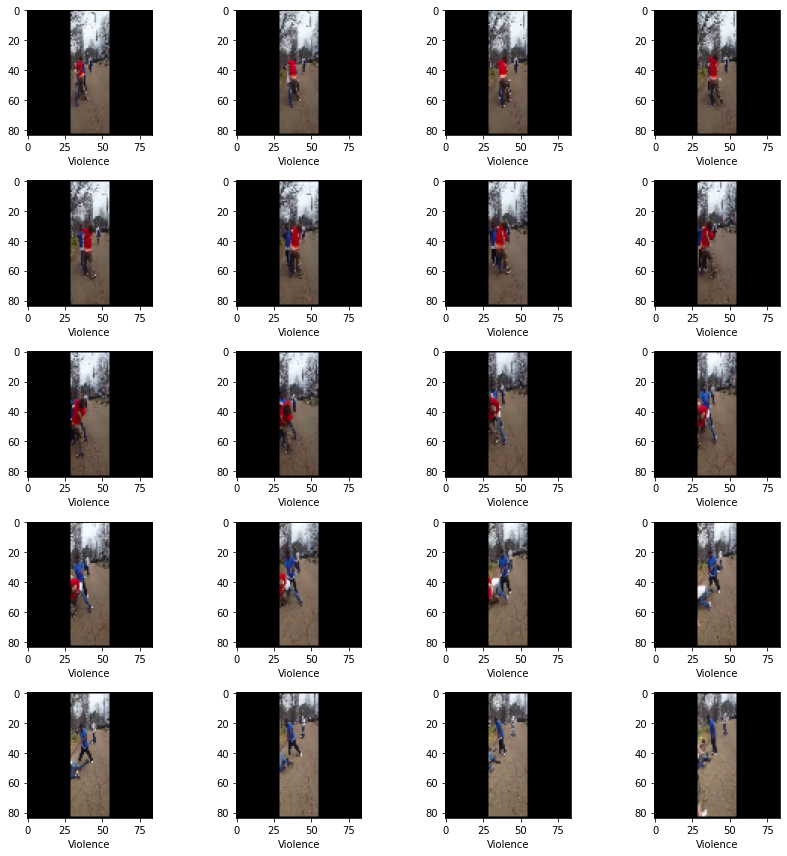

In [33]:
show_video(violence_videos[0], 'Violence')

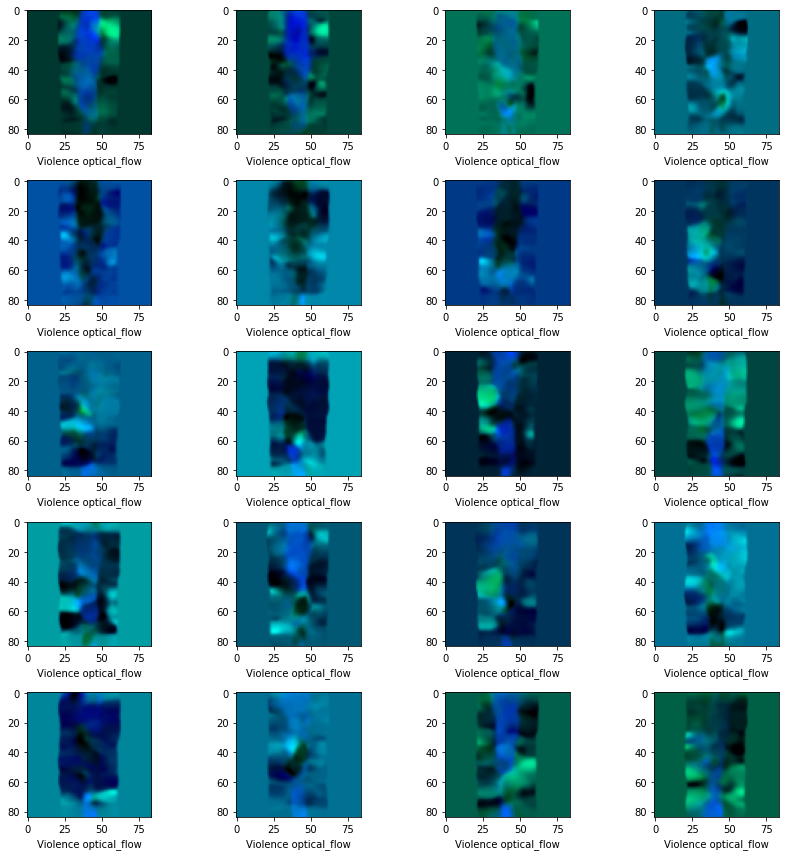

In [34]:
show_video(violence_videos_optical_flow[0], 'Violence', optical_flow=True)

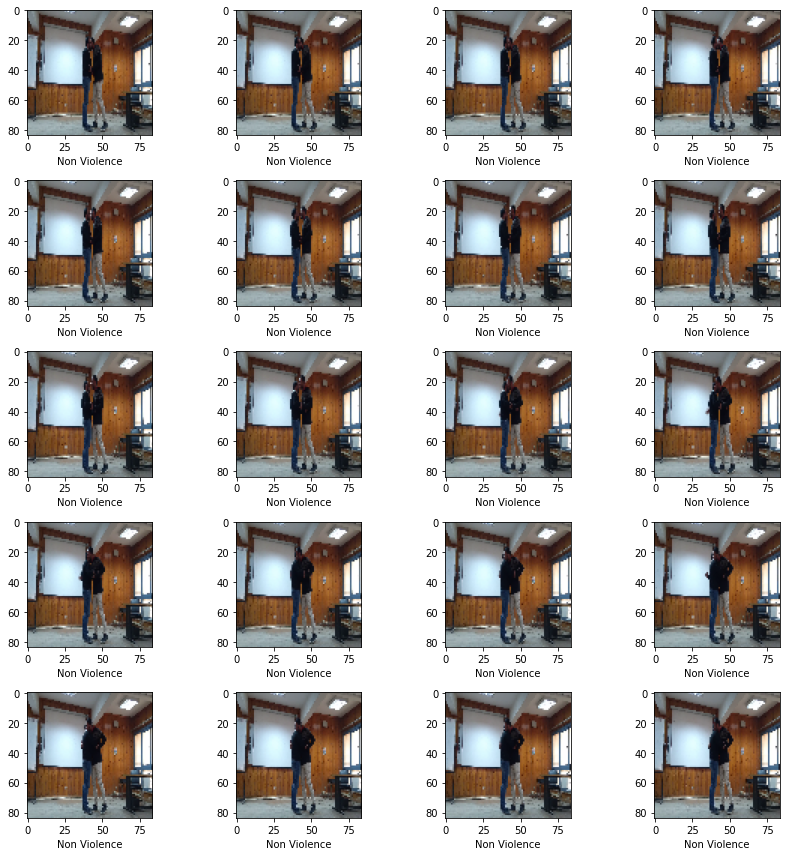

In [35]:
show_video(nonviolence_videos[0], 'Non Violence')

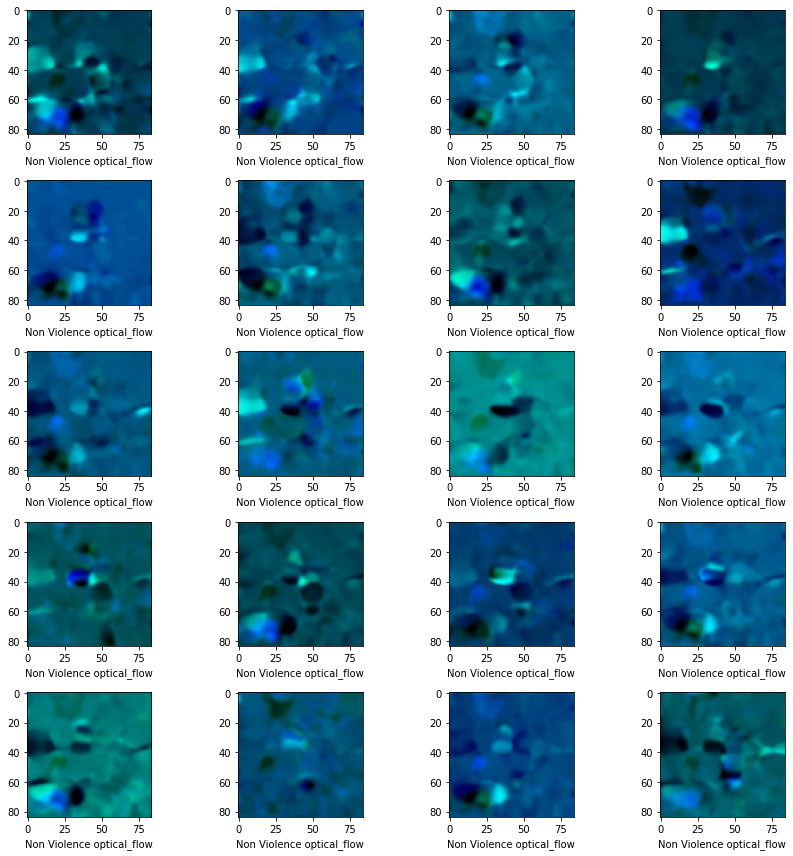

In [36]:
show_video(nonviolence_videos_optical_flow[0], 'Non Violence', optical_flow=True)

## Build Model

### Build Model Utils

In [37]:
WEIGHTS_NAME = ['rgb_kinetics_only',
                'flow_kinetics_only',
                'rgb_imagenet_and_kinetics',
                'flow_imagenet_and_kinetics']

# path to pretrained models with no top (no classification layer)
WEIGHTS_PATH_NO_TOP = {
    'rgb_kinetics_only': 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels_no_top.h5',
    'flow_kinetics_only': 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_kinetics_only_tf_dim_ordering_tf_kernels_no_top.h5',
    'rgb_imagenet_and_kinetics': 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/rgb_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5',
    'flow_imagenet_and_kinetics': 'https://github.com/dlpbc/keras-kinetics-i3d/releases/download/v0.2/flow_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5'
}


def conv3d_bn(x,
              filters,
              num_frames,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1, 1),
              use_bias=False,
              use_activation_fn=True,
              use_bn=True,
              name=None):
  
  if name is not None:
    bn_name = name + '_bn'
    conv_name = name + '_conv'
  else:
    bn_name = None
    conv_name = None

  x = tf.keras.layers.Conv3D(
      filters, (num_frames, num_row, num_col),
      strides=strides,
      padding=padding,
      use_bias=use_bias,
      name=conv_name)(x)

  if use_bn:
    bn_axis = 4
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)

  if use_activation_fn:
    x = tf.keras.layers.Activation('relu', name=name)(x)

  return x


def Inception_Inflated3d(include_top=True,
                         weights=None,
                         input_tensor=None,
                         input_shape=None,
                         dropout_prob=0.0,
                         endpoint_logit=True,
                         classes=400):
  if not (weights in WEIGHTS_NAME or weights is None or os.path.exists(weights)):
    raise ValueError('The `weights` argument should be either '
                       '`None` (random initialization) or %s' %
                       str(WEIGHTS_NAME) + ' '
                                           'or a valid path to a file containing `weights` values')

  if weights in WEIGHTS_NAME and include_top and classes != 400:
    raise ValueError('If using `weights` as one of these %s, with `include_top`'
                       ' as true, `classes` should be 400' % str(WEIGHTS_NAME))

  if input_tensor is None:
    img_input = tf.keras.layers.Input(shape=input_shape)
  else:
    if not K.is_keras_tensor(input_tensor):
      img_input = tf.keras.layers.Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor

  channel_axis = 4

  # Downsampling via convolution (spatial and temporal)
  x = conv3d_bn(img_input, 64, 7, 7, 7, strides=(2, 2, 2), padding='same', name='Conv3d_1a_7x7')

  # Downsampling (spatial only)
  x = tf.keras.layers.MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='MaxPool2d_2a_3x3')(x)
  x = conv3d_bn(x, 64, 1, 1, 1, strides=(1, 1, 1), padding='same', name='Conv3d_2b_1x1')
  x = conv3d_bn(x, 192, 3, 3, 3, strides=(1, 1, 1), padding='same', name='Conv3d_2c_3x3')

  # Downsampling (spatial only)
  x = tf.keras.layers.MaxPooling3D((1, 3, 3), strides=(1, 2, 2), padding='same', name='MaxPool2d_3a_3x3')(x)

  # Mixed 3b
  branch_0 = conv3d_bn(x, 64, 1, 1, 1, padding='same', name='Conv3d_3b_0a_1x1')

  branch_1 = conv3d_bn(x, 96, 1, 1, 1, padding='same', name='Conv3d_3b_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 128, 3, 3, 3, padding='same', name='Conv3d_3b_1b_3x3')

  branch_2 = conv3d_bn(x, 16, 1, 1, 1, padding='same', name='Conv3d_3b_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 32, 3, 3, 3, padding='same', name='Conv3d_3b_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_3b_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 32, 1, 1, 1, padding='same', name='Conv3d_3b_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_3b')

  # Mixed 3c
  branch_0 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_3c_0a_1x1')

  branch_1 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_3c_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 192, 3, 3, 3, padding='same', name='Conv3d_3c_1b_3x3')

  branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_3c_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 96, 3, 3, 3, padding='same', name='Conv3d_3c_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_3c_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_3c_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_3c')

  # Downsampling (spatial and temporal)
  x = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same', name='MaxPool2d_4a_3x3')(x)

  # Mixed 4b
  branch_0 = conv3d_bn(x, 192, 1, 1, 1, padding='same', name='Conv3d_4b_0a_1x1')

  branch_1 = conv3d_bn(x, 96, 1, 1, 1, padding='same', name='Conv3d_4b_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 208, 3, 3, 3, padding='same', name='Conv3d_4b_1b_3x3')

  branch_2 = conv3d_bn(x, 16, 1, 1, 1, padding='same', name='Conv3d_4b_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 48, 3, 3, 3, padding='same', name='Conv3d_4b_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4b_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4b_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_4b')

  # Mixed 4c
  branch_0 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_4c_0a_1x1')

  branch_1 = conv3d_bn(x, 112, 1, 1, 1, padding='same', name='Conv3d_4c_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 224, 3, 3, 3, padding='same', name='Conv3d_4c_1b_3x3')

  branch_2 = conv3d_bn(x, 24, 1, 1, 1, padding='same', name='Conv3d_4c_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4c_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4c_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4c_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_4c')

  # Mixed 4d
  branch_0 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_4d_0a_1x1')

  branch_1 = conv3d_bn(x, 128, 1, 1, 1, padding='same', name='Conv3d_4d_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 256, 3, 3, 3, padding='same', name='Conv3d_4d_1b_3x3')

  branch_2 = conv3d_bn(x, 24, 1, 1, 1, padding='same', name='Conv3d_4d_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4d_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4d_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4d_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_4d')

  # Mixed 4e
  branch_0 = conv3d_bn(x, 112, 1, 1, 1, padding='same', name='Conv3d_4e_0a_1x1')

  branch_1 = conv3d_bn(x, 144, 1, 1, 1, padding='same', name='Conv3d_4e_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 288, 3, 3, 3, padding='same', name='Conv3d_4e_1b_3x3')

  branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_4e_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 64, 3, 3, 3, padding='same', name='Conv3d_4e_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4e_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 64, 1, 1, 1, padding='same', name='Conv3d_4e_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_4e')

  # Mixed 4f
  branch_0 = conv3d_bn(x, 256, 1, 1, 1, padding='same', name='Conv3d_4f_0a_1x1')

  branch_1 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_4f_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 320, 3, 3, 3, padding='same', name='Conv3d_4f_1b_3x3')

  branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_4f_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_4f_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_4f_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_4f_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_4f')

  # Downsampling (spatial and temporal)
  x = tf.keras.layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding='same', name='MaxPool2d_5a_2x2')(x)

  # Mixed 5b
  branch_0 = conv3d_bn(x, 256, 1, 1, 1, padding='same', name='Conv3d_5b_0a_1x1')

  branch_1 = conv3d_bn(x, 160, 1, 1, 1, padding='same', name='Conv3d_5b_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 320, 3, 3, 3, padding='same', name='Conv3d_5b_1b_3x3')

  branch_2 = conv3d_bn(x, 32, 1, 1, 1, padding='same', name='Conv3d_5b_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_5b_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_5b_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_5b_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_5b')

  # Mixed 5c
  branch_0 = conv3d_bn(x, 384, 1, 1, 1, padding='same', name='Conv3d_5c_0a_1x1')

  branch_1 = conv3d_bn(x, 192, 1, 1, 1, padding='same', name='Conv3d_5c_1a_1x1')
  branch_1 = conv3d_bn(branch_1, 384, 3, 3, 3, padding='same', name='Conv3d_5c_1b_3x3')

  branch_2 = conv3d_bn(x, 48, 1, 1, 1, padding='same', name='Conv3d_5c_2a_1x1')
  branch_2 = conv3d_bn(branch_2, 128, 3, 3, 3, padding='same', name='Conv3d_5c_2b_3x3')

  branch_3 = tf.keras.layers.MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same', name='MaxPool2d_5c_3a_3x3')(x)
  branch_3 = conv3d_bn(branch_3, 128, 1, 1, 1, padding='same', name='Conv3d_5c_3b_1x1')

  x = tf.keras.layers.concatenate(
      [branch_0, branch_1, branch_2, branch_3],
      axis=channel_axis,
      name='Mixed_5c')

  if include_top:
    # Classification block
    x = tf.keras.layers.AveragePooling3D((2, 7, 7), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)
    x = tf.keras.layers.Dropout(dropout_prob)(x)

    x = conv3d_bn(x, classes, 1, 1, 1, padding='same',
                  use_bias=True, use_activation_fn=False, use_bn=False, name='Conv3d_6a_1x1')

    num_frames_remaining = int(x.shape[1])
    x = tf.keras.layers.Reshape((num_frames_remaining, classes))(x)

    # logits (raw scores for each class)
    x = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1, keepdims=False),
                output_shape=lambda s: (s[0], s[2]))(x)

    if not endpoint_logit:
      x = tf.keras.layers.Activation('softmax', name='prediction')(x)
  else:
    h = int(x.shape[2])
    w = int(x.shape[3])
    x = tf.keras.layers.AveragePooling3D((2, h, w), strides=(1, 1, 1), padding='valid', name='global_avg_pool')(x)

  inputs = img_input
  # create model
  model = tf.keras.Model(inputs, x, name='i3d_inception')

  # load weights
  if weights in WEIGHTS_NAME:
    if weights == WEIGHTS_NAME[0]:  # rgb_kinetics_only
      weights_url = WEIGHTS_PATH_NO_TOP['rgb_kinetics_only']
      model_name = 'i3d_inception_rgb_kinetics_only_no_top.h5'

    elif weights == WEIGHTS_NAME[1]:  # flow_kinetics_only
      weights_url = WEIGHTS_PATH_NO_TOP['flow_kinetics_only']
      model_name = 'i3d_inception_flow_kinetics_only_no_top.h5'

    elif weights == WEIGHTS_NAME[2]:  # rgb_imagenet_and_kinetics
      weights_url = WEIGHTS_PATH_NO_TOP['rgb_imagenet_and_kinetics']
      model_name = 'i3d_inception_rgb_imagenet_and_kinetics_no_top.h5'

    elif weights == WEIGHTS_NAME[3]:  # flow_imagenet_and_kinetics
      weights_url = WEIGHTS_PATH_NO_TOP['flow_imagenet_and_kinetics']
      model_name = 'i3d_inception_flow_imagenet_and_kinetics_no_top.h5'

    downloaded_weights_path = get_file(model_name, weights_url, cache_subdir='models')
    model.load_weights(downloaded_weights_path)

  elif weights is not None:
    model.load_weights(weights)

  return model

In [38]:
def add_i3d_top(base_model, classes):
  classifier = base_model.output
  classifier = Flatten()(classifier)
  classifier = Dense(classes, activation='sigmoid')(classifier)

  new_model = tf.keras.Model(inputs=base_model.input, outputs=classifier, name="i3d_with_top")

  return new_model

In [39]:
def layers_freeze(keras_model):
    for layer in keras_model.layers:
        layer.trainable = False

    return keras_model

  
def get_visual_model(input_shape, num_classes, type_model='rgb', with_top=True):
    # build model for optical flow data
    # and load pretrained weights (trained on imagenet and kinetics dataset)
    weights_name = f'{type_model}_imagenet_and_kinetics'
    i3d_model_without_top = Inception_Inflated3d(include_top=False,
                                                 weights=weights_name,
                                                 input_shape=input_shape,
                                                 classes=num_classes)
    i3d_model = layers_freeze(i3d_model_without_top)
    
    if with_top:
      i3d_model = add_i3d_top(i3d_model, num_classes)

      optimizer = keras.optimizers.Adam(lr=1e-4, decay=1e-6)
      i3d_model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])    
    return i3d_model

### Build Model Utils New

In [40]:
def get_visual_model_new(input_shape):

  model = Sequential()
  model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  optimizer = keras.optimizers.Adam(lr=1e-4, decay=1e-6)
  Callback_Stop_Early = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)
  model.compile(optimizer, loss="binary_crossentropy", metrics=["accuracy"])

  return model

### RGB Model

In [41]:
rgb_model = get_visual_model_new(input_shape=(MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, CHANNELS))

rgb_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 22, 82, 82, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 11, 41, 41, 16)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 11, 41, 41, 16)   64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 11, 41, 41, 16)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 39, 39, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 19, 19, 32)    0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Optical Flow Model

In [42]:
optical_flow_model = get_visual_model_new(input_shape=(MAX_SEQ_LENGTH-1, IMG_SIZE, IMG_SIZE, CHANNELS_OPTICAL_FLOW))

optical_flow_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 21, 82, 82, 16)    880       
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 10, 41, 41, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 10, 41, 41, 16)   64        
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 10, 41, 41, 16)    0         
                                                                 
 conv3d_4 (Conv3D)           (None, 8, 39, 39, 32)     13856     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 4, 19, 19, 32)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 4, 19, 19, 32)    128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 4, 19, 19, 32)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 2, 17, 17, 64)     55360     
                                                                 
 batch_normalization_5 (Batc  (None, 2, 17, 17, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 2, 17, 17, 64)     0         
                                                                 
 flatten_1 (Flatten)         (None, 36992)             0         
          

## Train Model

### RGB Model

In [45]:
Callback_Stop_Early = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)
rgb_model.load_weights('/content/drive/MyDrive/deepLearning/EyeVision-final-project/rgb_model_weights_new.h5')

rgb_history = rgb_model.fit(xTrain, yTrain, validation_data=(xTest,yTest), callbacks=Callback_Stop_Early, epochs=EPOCHS, batch_size=BATCH_SIZE)
rgb_model.save('/content/drive/MyDrive/deepLearning/EyeVision-final-project/rgb_model_new.h5')
rgb_model.save_weights('/content/drive/MyDrive/deepLearning/EyeVision-final-project/rgb_model_weights_new.h5')


Epoch 1/10
99/99 [==============================] - 890s 9s/step - loss: 0.5757 - accuracy: 0.7113 - val_loss: 0.6683 - val_accuracy: 0.6620
Epoch 2/10
99/99 [==============================] - 879s 9s/step - loss: 0.4139 - accuracy: 0.8134 - val_loss: 0.4931 - val_accuracy: 0.7573
Epoch 3/10
99/99 [==============================] - 882s 9s/step - loss: 0.2807 - accuracy: 0.8833 - val_loss: 0.5159 - val_accuracy: 0.7560
Epoch 4/10
99/99 [==============================] - 888s 9s/step - loss: 0.2227 - accuracy: 0.9116 - val_loss: 0.4677 - val_accuracy: 0.7789
Epoch 5/10
99/99 [==============================] - 887s 9s/step - loss: 0.1627 - accuracy: 0.9329 - val_loss: 0.4836 - val_accuracy: 0.8005
Epoch 6/10
99/99 [==============================] - 880s 9s/step - loss: 0.1349 - accuracy: 0.9514 - val_loss: 0.4939 - val_accuracy: 0.7980
Epoch 7/10
99/99 [==============================] - 883s 9s/step - loss: 0.1278 - accuracy: 0.9564 - val_loss: 0.5314 - val_accuracy: 0.8005
Epoch 8/10
99

### Optical Flow Model

In [46]:
Callback_Stop_Early = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)
optical_flow_model.load_weights('/content/drive/MyDrive/deepLearning/EyeVision-final-project/optical_flow_model_weights_new.h5')

optical_flow_history = optical_flow_model.fit(xTrain_optical_flow,
                                              yTrain_optical_flow,
                                              validation_data=(xTest_optical_flow,yTest_optical_flow),
                                              callbacks=Callback_Stop_Early,
                                              epochs=EPOCHS,
                                              batch_size=BATCH_SIZE)
optical_flow_model.save('/content/drive/MyDrive/deepLearning/EyeVision-final-project/optical_flow_model_new.h5')
optical_flow_model.save_weights('/content/drive/MyDrive/deepLearning/EyeVision-final-project/optical_flow_model_weights_new.h5')

Epoch 1/10
99/99 [==============================] - 823s 8s/step - loss: 0.8239 - accuracy: 0.5914 - val_loss: 0.7566 - val_accuracy: 0.5032
Epoch 2/10
99/99 [==============================] - 780s 8s/step - loss: 0.5403 - accuracy: 0.7332 - val_loss: 0.6160 - val_accuracy: 0.6773
Epoch 3/10
99/99 [==============================] - 784s 8s/step - loss: 0.3979 - accuracy: 0.8216 - val_loss: 0.6413 - val_accuracy: 0.6849
Epoch 4/10
99/99 [==============================] - 777s 8s/step - loss: 0.3072 - accuracy: 0.8725 - val_loss: 0.8731 - val_accuracy: 0.6328
Epoch 5/10
99/99 [==============================] - 786s 8s/step - loss: 0.2042 - accuracy: 0.9275 - val_loss: 1.3238 - val_accuracy: 0.5972
Epoch 6/10
99/99 [==============================] - 789s 8s/step - loss: 0.1568 - accuracy: 0.9475 - val_loss: 0.9121 - val_accuracy: 0.6557
Epoch 7/10
99/99 [==============================] - 780s 8s/step - loss: 0.1227 - accuracy: 0.9612 - val_loss: 0.9406 - val_accuracy: 0.6569
Epoch 8/10
99

## Results 

### Visualization of Loss and Accuracy

RGB Model

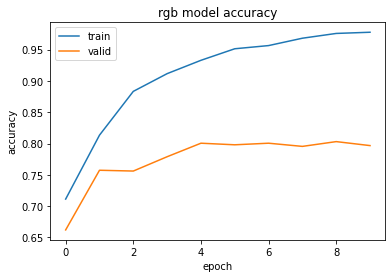

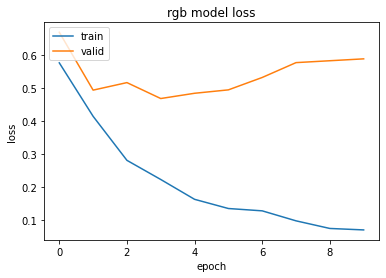

In [48]:
plt.plot(rgb_history.history['accuracy'])
plt.plot(rgb_history.history['val_accuracy'])
plt.title('rgb model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(rgb_history.history['loss'])
plt.plot(rgb_history.history['val_loss'])
plt.title('rgb model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Optical Flow Model

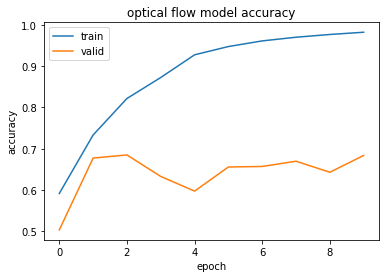

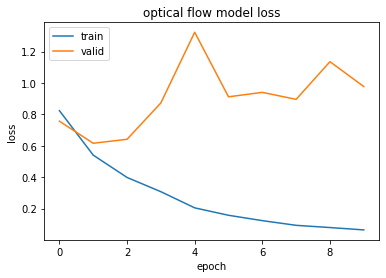

In [49]:
plt.plot(optical_flow_history.history['accuracy'])
plt.plot(optical_flow_history.history['val_accuracy'])
plt.title('optical flow model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(optical_flow_history.history['loss'])
plt.plot(optical_flow_history.history['val_loss'])
plt.title('optical flow model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Model Performance Evaluation

RGB Model

In [50]:
test_loss, test_acc = rgb_model.evaluate(xTest,yTest)
print("Model test accuracy is : "+"{:.2f}".format(test_acc*100)+"%")

25/25 [==============================] - 5s 194ms/step - loss: 0.5878 - accuracy: 0.7967
Model test accuracy is : 79.67%


In [51]:
y_pred = []
conf_mat = [[0,0],[0,0]]

for i in range (len(yTest)):
  test_video = xTest[i]
  test_video = tf.reshape(test_video, (1,MAX_SEQ_LENGTH,IMG_SIZE,IMG_SIZE,CHANNELS))
  result = rgb_model.predict(test_video)
  if(result > 0.5 and yTest[i] == 1):
    conf_mat[0][0] += 1
  elif(result > 0.5 and yTest[i] == 0):
    conf_mat[0][1] += 1
  elif(result <= 0.5 and yTest[i] == 1):
    conf_mat[1][0] += 1
  else:
    conf_mat[1][1] += 1

print(conf_mat)

[[329, 92], [68, 298]]


Optical Flow Model

In [52]:
test_loss, test_acc = optical_flow_model.evaluate(xTest_optical_flow,yTest_optical_flow)
print("Model test accuracy is : "+"{:.2f}".format(test_acc*100)+"%")

25/25 [==============================] - 4s 163ms/step - loss: 0.9775 - accuracy: 0.6836
Model test accuracy is : 68.36%


In [53]:
y_pred = []
conf_mat = [[0,0],[0,0]]

for i in range (len(yTest_optical_flow)):
  test_video = xTest_optical_flow[i]
  test_video = tf.reshape(test_video, (1,MAX_SEQ_LENGTH-1,IMG_SIZE,IMG_SIZE,CHANNELS_OPTICAL_FLOW))
  result = optical_flow_model.predict(test_video)
  if(result > 0.5 and yTest_optical_flow[i] == 1):
    conf_mat[0][0] += 1
  elif(result > 0.5 and yTest_optical_flow[i] == 0):
    conf_mat[0][1] += 1
  elif(result <= 0.5 and yTest_optical_flow[i] == 1):
    conf_mat[1][0] += 1
  else:
    conf_mat[1][1] += 1

print(conf_mat)

[[227, 75], [174, 311]]


### Single Prediction

In [54]:
def singlePrediction(video):

  rgb_video = video
  optical_flow_video = get_optical_flow(video)

  show_video(video = video, label='')
  show_video(video = get_optical_flow(video), label='', optical_flow = True)
  
  rgb_video = tf.reshape(rgb_video, (1,MAX_SEQ_LENGTH,IMG_SIZE,IMG_SIZE,CHANNELS))
  optical_flow_video = tf.reshape(optical_flow_video, (1,MAX_SEQ_LENGTH-1,IMG_SIZE,IMG_SIZE,CHANNELS_OPTICAL_FLOW))

  rgb_model_predication = load_model('/content/drive/MyDrive/deepLearning/EyeVision-final-project/rgb_model_new.h5')
  optical_flow_model_predication = load_model('/content/drive/MyDrive/deepLearning/EyeVision-final-project/optical_flow_model_new.h5')

  rgb_result = rgb_model_predication.predict(rgb_video)
  optical_flow_result = optical_flow_model_predication.predict(optical_flow_video)

  print(rgb_result)
  print(optical_flow_result)

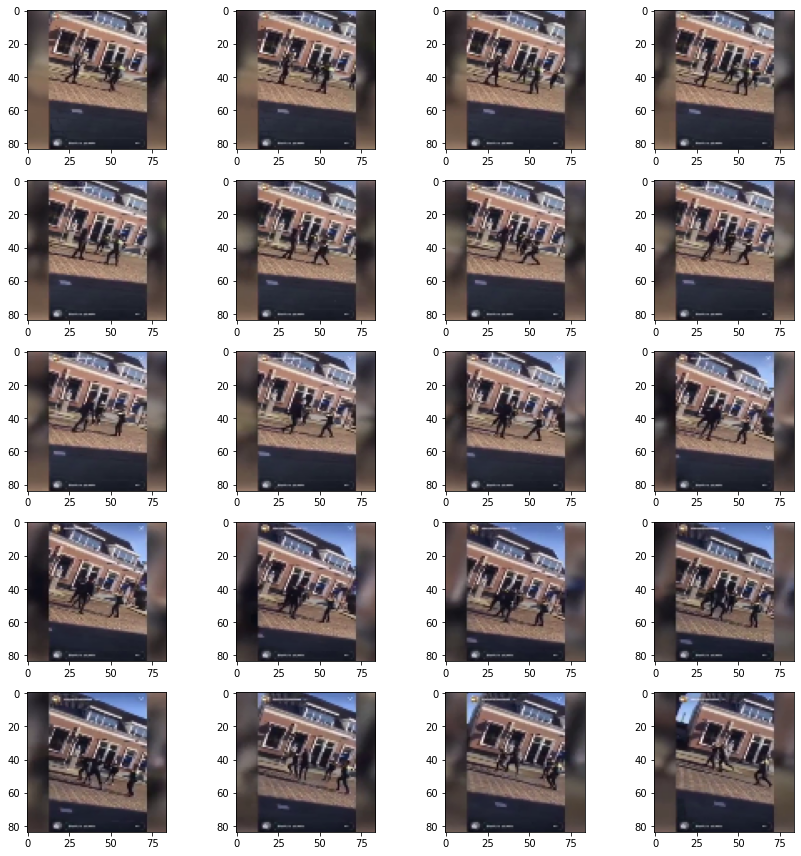

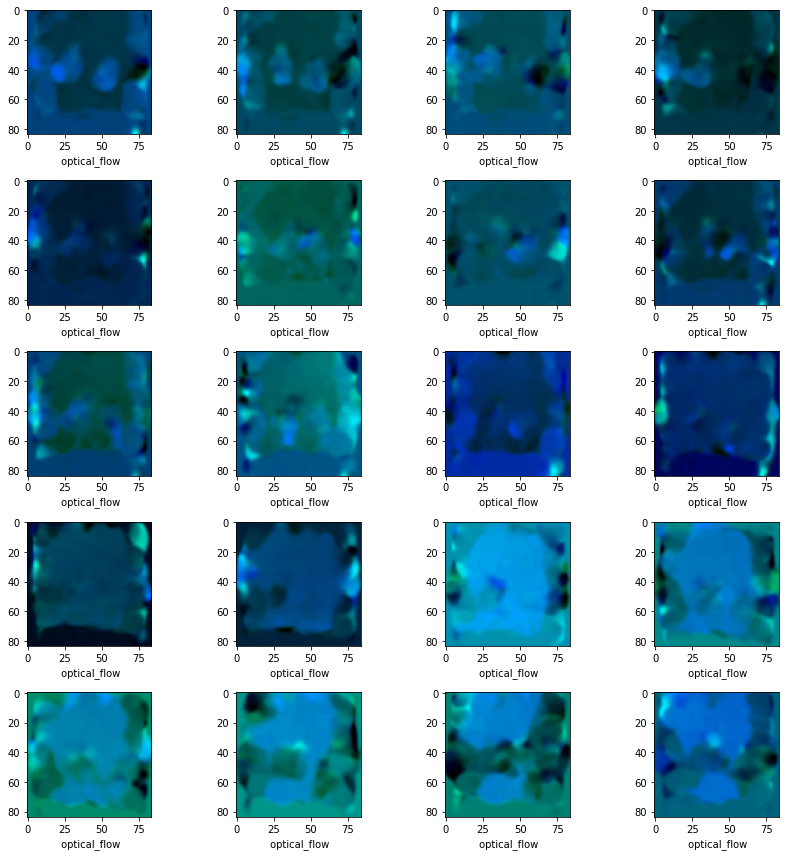

[[0.9648037]]
[[0.00028914]]


In [55]:
video = load_video('/content/drive/MyDrive/deepLearning/EyeVision-final-project/test/Violence/V_993.mp4')
singlePrediction(video)